In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Cleaning**

In [2]:
df = pd.read_csv('synthetic_data.csv')

# Check for missing values
df.isnull().sum()

x         0
y         0
z         0
status    0
dtype: int64

In [3]:
# Remove duplicates
df.drop_duplicates()

,x,y,z,status
0,-0.152375,-0.898320,-0.371662,idle
1,-0.133481,-0.877780,-0.385113,idle
2,-0.121285,-0.909976,-0.381254,idle
3,-0.127859,-0.899945,-0.426131,idle
4,-0.131367,-0.919183,-0.425946,idle
...,...,...,...,...
99995,0.683156,0.519731,-0.366067,soft_concrete
99996,0.787088,0.319512,-0.601208,soft_concrete
99997,0.742647,0.382496,-0.581437,soft_concrete
99998,0.627654,0.409057,-0.536827,soft_concrete


**Normalization of Data**

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

In [5]:
df.head()

,x,y,z,status
0,-1.027891,-0.970761,-0.582901,idle
1,-0.989418,-0.938024,-0.619480,idle
2,-0.964582,-0.989339,-0.608987,idle
3,-0.977969,-0.973351,-0.731030,idle
4,-0.985113,-1.004014,-0.730528,idle


**Feature Engineering**

In [5]:
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [6]:
window_size = 10

# Calculate rolling mean, standard deviation, max, and min
df['rolling_mean'] = df['magnitude'].rolling(window=window_size).mean()
df['rolling_std'] = df['magnitude'].rolling(window=window_size).std()
df['rolling_max'] = df['magnitude'].rolling(window=window_size).max()
df['rolling_min'] = df['magnitude'].rolling(window=window_size).min()


In [7]:
from scipy.fft import fft

# Compute FFT to analyze frequency
df['fft'] = fft(df['magnitude'])
df['fft_amplitude'] = np.abs(df['fft'][:len(df)//2])


In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['status_encoded'] = encoder.fit_transform(df['status'])


**Train Test Split**

In [9]:
from sklearn.model_selection import train_test_split

X = df[['magnitude', 'rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min']]
y = df['status_encoded']

# Handle NaN values generated by rolling operations
X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Model**

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [11]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4963
           1       0.94      0.97      0.96      5029
           2       0.97      0.93      0.95      5133
           3       0.96      0.96      0.96      4874

    accuracy                           0.96     19999
   macro avg       0.96      0.96      0.96     19999
weighted avg       0.96      0.96      0.96     19999

Accuracy: 0.96


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f}")


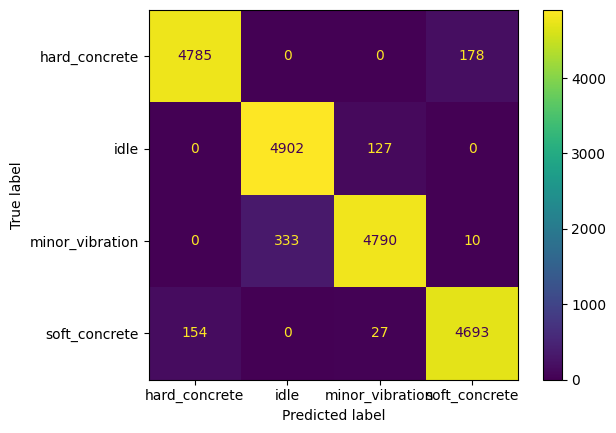

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()


In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=encoder.classes_))


                 precision    recall  f1-score   support

  hard_concrete       0.97      0.96      0.97      4963
           idle       0.94      0.97      0.96      5029
minor_vibration       0.97      0.93      0.95      5133
  soft_concrete       0.96      0.96      0.96      4874

       accuracy                           0.96     19999
      macro avg       0.96      0.96      0.96     19999
   weighted avg       0.96      0.96      0.96     19999



In [ ]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_acc = baseline.score(X_test, y_test)
print(f"Baseline Accuracy: {baseline_acc:.2f}")


Baseline Accuracy: 0.24


**Save Model**

In [13]:
import joblib

# Save the model to a file
joblib.dump(clf, "predictive_maintenance_model.pkl")

['predictive_maintenance_model.pkl']

In [17]:
df.head()

,x,y,z,status,magnitude,rolling_mean,rolling_std,rolling_max,rolling_min,fft,fft_amplitude,status_encoded
0,-1.027891,-0.970761,-0.582901,idle,1.529284,NaN,NaN,NaN,NaN,169747.678415- 0.000000j,169747.678415,1
1,-0.989418,-0.938024,-0.619480,idle,1.497528,NaN,NaN,NaN,NaN,-6390.727148+ 9529.477330j,11473.984994,1
2,-0.964582,-0.989339,-0.608987,idle,1.509992,NaN,NaN,NaN,NaN,99.553973- 7009.586826j,7010.293750,1
3,-0.977969,-0.973351,-0.731030,idle,1.561487,NaN,NaN,NaN,NaN,2141.946018+ 3256.994012j,3898.197370,1
4,-0.985113,-1.004014,-0.730528,idle,1.584980,NaN,NaN,NaN,NaN,24.485652+ 0.708724j,24.495907,1


In [18]:
df.to_csv("test.csv", index=False)

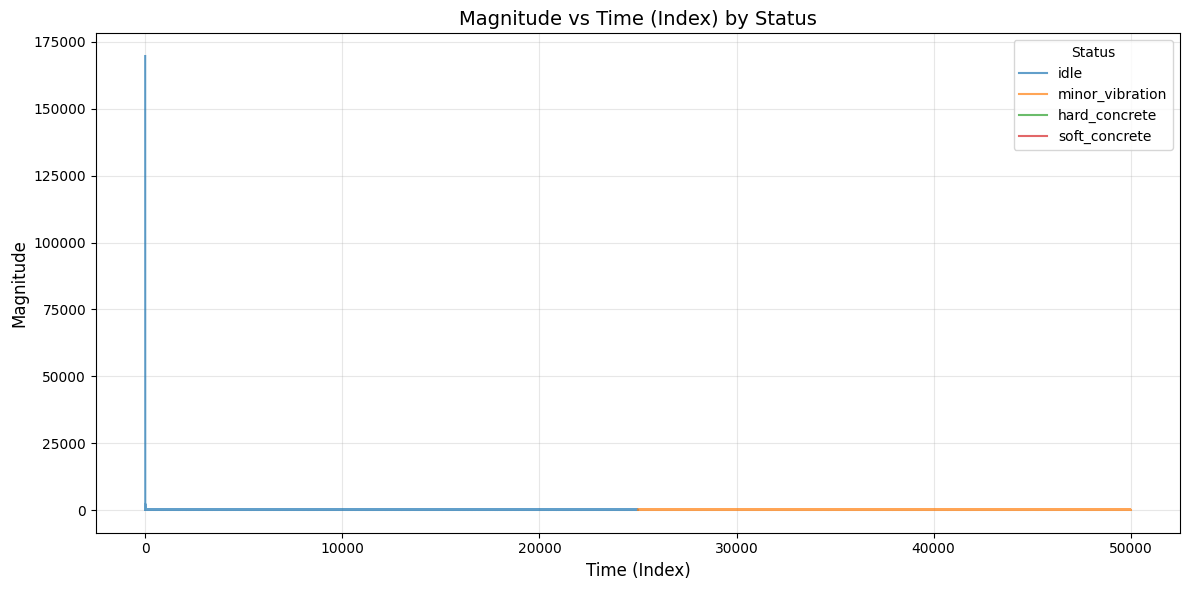

In [20]:
# Prepare the plot
plt.figure(figsize=(12, 6))

# Get unique statuses
statuses = df['status'].unique()

# Plot magnitude against the index for each status
for status in statuses:
    subset = df[df['status'] == status]
    plt.plot(
        subset.index, 
        subset['fft_amplitude'], 
        label=status, 
        alpha=0.7
    )

# Customize the plot
plt.title('Magnitude vs Time (Index) by Status', fontsize=14)
plt.xlabel('Time (Index)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend(title='Status', fontsize=10, loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()

# Display the plot
plt.show()



In [24]:
# Group the data by 'status' and calculate the minimum and maximum fft_amplitude
min_max_fft_amplitude = df.groupby('status_encoded')['fft_amplitude'].agg(['min', 'max']).reset_index()

# Display the results
print(min_max_fft_amplitude)


   status_encoded       min            max
0               0  0.000000       0.000000
1               1  0.372834  169747.678415
2               2  0.493013     284.746435
3               3  0.000000       0.000000


In [23]:
np.nan_to_num(df['fft_amplitude'])

array([169747.67841481,  11473.98499436,   7010.29375002, ...,
            0.        ,      0.        ,      0.        ])